In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.stats import kurtosis, skew, normaltest, norm, probplot
from pprint import pprint
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Initial Data Exploration

In [2]:
raw_data = pd.read_csv('showwcase_sessions.csv')
raw_data.head()
raw_data.dtypes

,session_id,customer_id,login_date,projects_added,likes_given,comment_given,inactive_status,bug_occured,session_projects_added,session_likes_given,session_comments_given,inactive_duration,bugs_in_session,session_duration
0,624205.0,80746.0,10/30/19,False,True,True,True,False,0.0,24.0,3.0,1146.0,0.0,1564.0
1,624241.0,24520.0,10/30/19,True,True,True,True,False,2.0,3.0,5.0,133.0,0.0,1766.0
2,111002.0,32047.0,10/30/19,True,True,True,True,False,1.0,5.0,5.0,1571.0,0.0,2230.0
3,545113.0,23404.0,10/30/19,True,True,True,False,False,1.0,10.0,21.0,0.0,0.0,633.0
4,750269.0,40235.0,10/30/19,True,True,False,True,False,3.0,16.0,0.0,1405.0,0.0,1679.0


session_id                float64
customer_id               float64
login_date                 object
projects_added             object
likes_given                object
comment_given              object
inactive_status            object
bug_occured                object
session_projects_added    float64
session_likes_given       float64
session_comments_given    float64
inactive_duration         float64
bugs_in_session           float64
session_duration          float64
dtype: object

In [3]:
# convert the login_date field into actual datetime objects for ease of analysis
raw_data['login_date'] = pd.to_datetime(raw_data['login_date'], infer_datetime_format=True)
raw_data['login_date']

0     2019-10-30
1     2019-10-30
2     2019-10-30
3     2019-10-30
4     2019-10-30
         ...    
297   2019-10-01
298   2019-10-01
299   2019-10-01
300          NaT
301          NaT
Name: login_date, Length: 302, dtype: datetime64[ns]

In [4]:
# Is there any missing data?
raw_data.isna().sum()

session_id                2
customer_id               2
login_date                2
projects_added            2
likes_given               2
comment_given             2
inactive_status           2
bug_occured               2
session_projects_added    2
session_likes_given       3
session_comments_given    2
inactive_duration         2
bugs_in_session           2
session_duration          2
dtype: int64

In [5]:
# show the rows that are NaN
raw_data[raw_data.isnull().any(axis=1)]

,session_id,customer_id,login_date,projects_added,likes_given,comment_given,inactive_status,bug_occured,session_projects_added,session_likes_given,session_comments_given,inactive_duration,bugs_in_session,session_duration
35,862128.0,23404.0,2019-10-26,True,False,True,True,False,2.0,NaN,2.0,1120.0,0.0,95.0
300,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There is only 1 rows that is not all NaN.

In [6]:
# Since there is only 1 row that is not all NaN, it is fine to drop it
clean_data = raw_data.dropna(how='any')
clean_data.isna().sum()

session_id                0
customer_id               0
login_date                0
projects_added            0
likes_given               0
comment_given             0
inactive_status           0
bug_occured               0
session_projects_added    0
session_likes_given       0
session_comments_given    0
inactive_duration         0
bugs_in_session           0
session_duration          0
dtype: int64

## Understanding the Underlying Structure of the Data

In [7]:
# explore the correlation of the features
corr = clean_data.corr()
corr

,session_id,customer_id,session_projects_added,session_likes_given,session_comments_given,inactive_duration,bugs_in_session,session_duration
session_id,1.000000,-0.041766,0.107919,-0.111805,0.087228,0.051335,-0.160055,-0.007147
customer_id,-0.041766,1.000000,0.157838,-0.030708,-0.035146,-0.014802,0.049826,-0.056896
session_projects_added,0.107919,0.157838,1.000000,-0.014775,-0.065215,0.001022,-0.038429,0.018398
session_likes_given,-0.111805,-0.030708,-0.014775,1.000000,0.048944,-0.076404,0.032711,-0.057032
session_comments_given,0.087228,-0.035146,-0.065215,0.048944,1.000000,0.011550,-0.020312,0.010574
inactive_duration,0.051335,-0.014802,0.001022,-0.076404,0.011550,1.000000,0.137024,0.073598
bugs_in_session,-0.160055,0.049826,-0.038429,0.032711,-0.020312,0.137024,1.000000,-0.032970
session_duration,-0.007147,-0.056896,0.018398,-0.057032,0.010574,0.073598,-0.032970,1.000000


In [8]:
corr[corr > 0.5]    # show any rows with correlation > 0.5

,session_id,customer_id,session_projects_added,session_likes_given,session_comments_given,inactive_duration,bugs_in_session,session_duration
session_id,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
session_projects_added,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
session_likes_given,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
session_comments_given,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
inactive_duration,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
bugs_in_session,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
session_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


The dataset seems very random. There are no strong correlations among any of the numerical variables.

### Are any variables normally distributed?

To determine normalcy of the numerical variables (session_projects_added, session_likes_given, session_comments_given, inactive_duration, bugs_in_session, session_duration), I will perform the follow tests of normality:
* Normal Probability Plots 
* KDE Plots
* Skewness and Kurtosis Tests
* Hypothesis Testing

### Normal Probability Plots

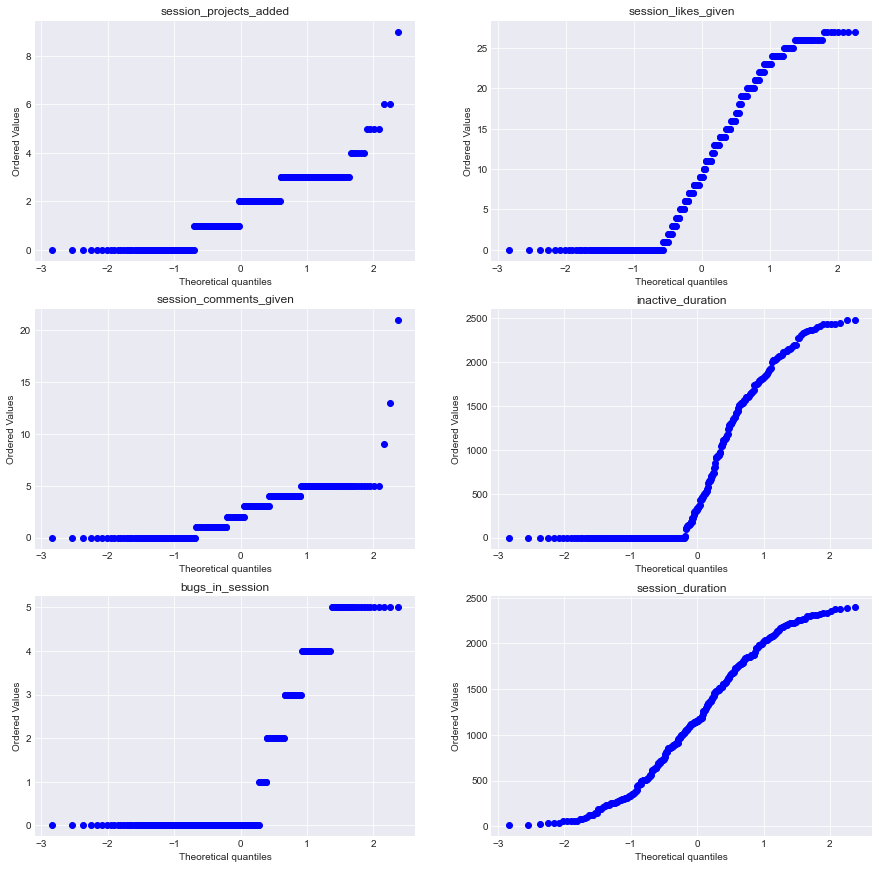

In [9]:
cols = raw_data.iloc[:,8:].columns    # grab all the numerical column names

fig, ax = plt.subplots(figsize=(15,15))
t = ax.axis('off')
style.use('seaborn-darkgrid')
for a in range(6):
    ax = fig.add_subplot(3,2, a+1)
    x = probplot(raw_data[cols[a]], dist=norm, plot=ax, fit=True)
    title = ax.set_title(cols[a])

Upon visual inspection of the Normal Probability plots, it does not seem that any variables are normally distributed. If they were normally distributed then the points would appear to be in a straight line, or have very little curvature.

### Histograms with KDE Plots

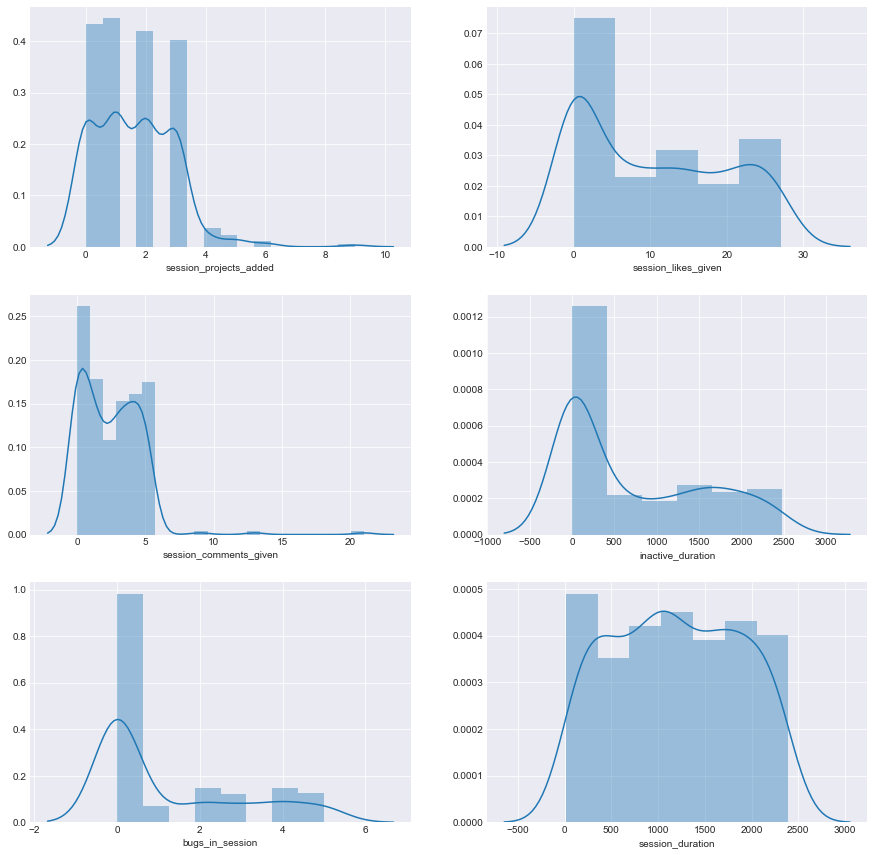

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
t = ax.axis('off')
style.use('seaborn-darkgrid')
for a in range(6):
    ax = fig.add_subplot(3,2, a+1)
    x = sns.distplot(raw_data[cols[a]], kde=True)
    #title = ax.set_title(cols[a])

The KDE Plots seem to confirm what the normal probablity plots suggest. None of the varibles seem to be normally distributed. I can stop the normalcy tests here because visual inspection has failed to confirm the normalcy of the variables, but for the sake of completeness, I will conduct the skewness and kurtosis tests and the hypotheis tests.

### Skewness and Kurtosis Tests

In [11]:
subset = clean_data[cols]
kurtosis_test = kurtosis(subset)
skewness_test = skew(subset)

kurtosis_test
skewness_test

array([ 2.46387073, -1.35231508, 15.25350419, -1.06734957, -0.50303258,
       -1.1671208 ])

array([0.93104209, 0.32780673, 2.29075451, 0.68284384, 1.02511091,
       0.0108972 ])

In [12]:
# Note: Alpha level = 0.01
# I am using a more stringent alpha level because the data sample size is quite small

normality_test = []
N = len(subset)
kurt_const = np.sqrt(24/N)
skew_const = np.sqrt(6/N)
for s, k in zip(skewness_test, kurtosis_test):
    Z_skew_val = s / skew_const
    Z_kurt_val = k / kurt_const
    normality_test.append((Z_skew_val, Z_kurt_val))

print('  Skewness                Kurtosis')
normality_test

  Skewness                Kurtosis


[(6.572480193441041, 8.69656787614485),
 (2.3140771806851466, -4.773180568961154),
 (16.17106115350199, 53.83932409469518),
 (4.820381007906988, -3.767355920879304),
 (7.236537633517435, -1.775522136742505),
 (0.07692633436317134, -4.119512106539933)]

The kurtosis and skewness z-scores must be within -2.58 and +2.58 for the variable to be considered normal. By this criterion, none of the variables qualify as having a normal distribution. 

### Hypothesis Testing

In [13]:
alpha_level = 0.01
H0 = "H0: The variable is normally distributed."
H1 = "H1: The variable is not normally distributed."
temp, p = normaltest(subset)

print(f"{H0}\n{H1}\n\nReject or Fail to Reject H0?\n")
for col, i in zip(cols,p):
    if i < alpha_level:
        print(f"{col}: Reject H0")
    else:
        print(f"{col}: Fail to reject H0")

H0: The variable is normally distributed.
H1: The variable is not normally distributed.

Reject or Fail to Reject H0?

session_projects_added: Reject H0
session_likes_given: Reject H0
session_comments_given: Reject H0
inactive_duration: Reject H0
bugs_in_session: Reject H0
session_duration: Reject H0


The p-values for all the variables are extremely small and therefore we reject the null hypothesis (since all p-values are less than alpha) for all the variables in question.

All the tests of normalcy conducted above confirm that **none** of the variables tested are normally distributed.

## Check for Data Integrity Issues

In [14]:
col_names = raw_data.columns.to_list()
dtypes_ = raw_data.dtypes

for c in col_names:
    if dtypes_[c] == 'float64':
        print(f"{c}: {raw_data[c].nunique()}")

session_id: 300
customer_id: 48
session_projects_added: 8
session_likes_given: 28
session_comments_given: 9
inactive_duration: 170
bugs_in_session: 6
session_duration: 279


The observations in session_id column are all unique indicating that there are no data integrity issues in this column. Furthermore, there are total of 48 unique customer IDs indicating that there were 48 users in October 2019 that used Showwcase.

In [15]:
# Check the boolean rows for consistency with their corresponding numerical rows

zero_or_more_cols = {'projects_added':'session_projects_added',  
                     'likes_given':'session_likes_given',
                     'comment_given':'session_comments_given',
                     'bug_occured':'bugs_in_session',
                     'inactive_status':'inactive_duration'}

validated = {}

# checks if boolean variable had True then the corresponding numerical value was > 0
# if boolean variable had False then the corresponding numerical value should be 0
for k, v in zero_or_more_cols.items():
    false_vals = clean_data[clean_data[k] == False]
    true_vals = clean_data[clean_data[k] == True]
    
    num_vals_false = (false_vals[v] == 0).all()
    num_vals_true = (true_vals[v] > 0).all()

    validated[v] = (num_vals_false, num_vals_true)
    
pprint(validated)

{'bugs_in_session': (True, True),
 'inactive_duration': (True, True),
 'session_comments_given': (True, True),
 'session_likes_given': (True, True),
 'session_projects_added': (True, True)}


All the boolean variables seem to be consistent with their corresponding numerical columns.

## User Engagement Analysis

For the purpose of analysis, I am defining user engagament as the **amount of time the user is actually performing activities, such as adding projects, liking posts, or commenting on posts**. The goal of this analysis will be to find insights that could help Showwcase to maximize and improve user engagement.

<AxesSubplot:title={'center':'Day vs # of customers logged in'}, xlabel='login_date', ylabel='# of customers logged in'>

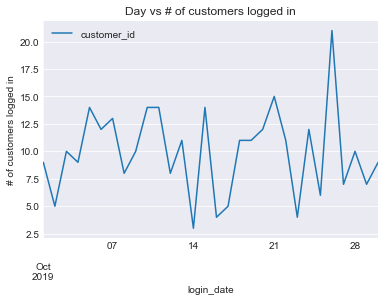

In [16]:
groupby_date = clean_data[['customer_id', 'login_date']].groupby('login_date').agg('count')
groupby_date.plot(title='Day vs # of customers logged in', ylabel='# of customers logged in')

Upon visual inspection of the above plot of login_date vs # of customers, a rough patterns seems to emerge. At the beginning of every week (Monday/Tuesday), the number of users always drops significantly. From the middle of the week (roughly Wednesday onwards), the number of customers using the platform rises again and continues to rise through the weekend. This cycle seems to repeat for every week of October 2019. 

It is worth looking into what causes this pattern of usage. One obvious explanation could be that the start of the week is usually when people are the most busy with work (and perhaps motivation levels are also low during the start of the week). As the week progresses, from Wednesday onwards, people start having more free time in which they can log in to Showwcase and use the platform more to perform any number of activities from adding projects to liking and commenting on posts.

In [17]:
# calculate inactivity ratio
clean_data['inactivity_ratio'] = clean_data['inactive_duration'] / clean_data['session_duration']

# standardize the ratio so that it is between 0 and 1
clean_data['inactivity_ratio'] = round((clean_data['inactivity_ratio'] - clean_data['inactive_duration'].min()) / \
                                 (clean_data['inactivity_ratio'].max() - clean_data['inactivity_ratio'].min()), 1)

clean_data[['customer_id', 'inactivity_ratio']]

,customer_id,inactivity_ratio
0,80746.0,0.0
1,24520.0,0.0
2,32047.0,0.0
3,23404.0,0.0
4,40235.0,0.0
...,...,...
295,40572.0,0.0
296,87323.0,0.0
297,51243.0,0.0
298,23083.0,0.0


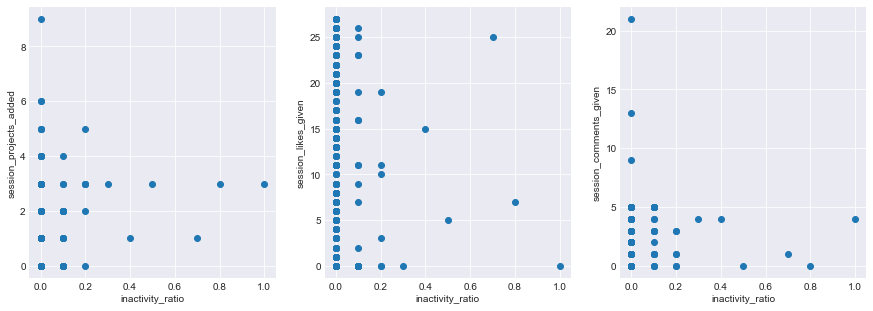

In [18]:
plot_cols = ['session_projects_added', 'session_likes_given', 'session_comments_given']
fig, axes = plt.subplots(1,3, figsize=(15, 5))
for i, ax in enumerate(axes.ravel()):
    l = ax.scatter(clean_data['inactivity_ratio'], clean_data[plot_cols[i]])
    m = ax.set_ylabel(plot_cols[i])
    n = ax.set_xlabel('inactivity_ratio')

,inactivity_ratio,session_comments_given,session_likes_given,session_projects_added
0,0.0,643.0,2844.0,426.0
1,0.1,56.0,188.0,28.0
2,0.2,8.0,43.0,16.0
3,0.3,4.0,0.0,3.0
4,0.4,4.0,15.0,1.0
5,0.5,0.0,5.0,3.0
6,0.7,1.0,25.0,1.0
7,0.8,0.0,7.0,3.0
8,1.0,4.0,0.0,3.0


<AxesSubplot:xlabel='inactivity_ratio'>

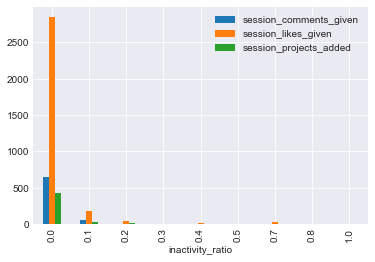

In [19]:
groupby_inactivity_comments = clean_data[['inactivity_ratio', 'session_comments_given', 'session_likes_given', \
                                          'session_projects_added']].groupby('inactivity_ratio').agg('sum')
groupby_inactivity_comments = groupby_inactivity_comments.reset_index()
groupby_inactivity_comments
groupby_inactivity_comments.plot(x='inactivity_ratio', kind='bar')

From the above scatter and bar plots, it is clear that the more the person remains inactive, the less they are actually "enagaged" with the content on the website. What Showwcase could target is some form of method where users are encouraged to keep their sessions short as they engage on the platform (adding projects, liking/commenting on posts) and log out once they are done. I believe if short, quick sessions are encouraged then people will be more productive in those sessions and perhaps they will be even more likely to visit Showwcase again and have another highly engaging session. 

Performing an A/B test would be one way to confirm or reject this hypothesis.

In [20]:
clean_data['bugs_in_session'].value_counts()

0.0    183
2.0     28
4.0     28
5.0     24
3.0     23
1.0     13
Name: bugs_in_session, dtype: int64

In [21]:
groupby_bugs = clean_data[['bugs_in_session', 'inactivity_ratio']].groupby('bugs_in_session').agg(['min', 'max'])
groupby_bugs['# of sessions'] = clean_data[['customer_id', 'bugs_in_session']].groupby('bugs_in_session').agg(['count'])
groupby_bugs

inactivity_ratio      # of sessions
                             min  max              
bugs_in_session                                    
0.0                          0.0  0.5           183
1.0                          0.0  0.1            13
2.0                          0.0  0.8            28
3.0                          0.0  0.7            23
4.0                          0.0  1.0            28
5.0                          0.0  0.2            24

<AxesSubplot:xlabel='bugs_in_session'>

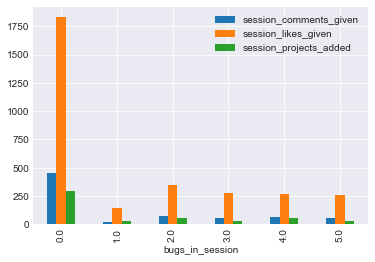

In [22]:
groupby_bugs_comments = clean_data[['bugs_in_session', 'session_comments_given', 'session_likes_given', 'session_projects_added']].groupby('bugs_in_session').agg('sum')
groupby_bugs_comments = groupby_bugs_comments.reset_index()
groupby_bugs_comments.plot(x='bugs_in_session', kind='bar')

From the above plot, it can be said that bugs are obviously not good for user engagement. Although we observe some anomalous behavior when the user enegagement decrease at one bug occuring and then increases again at two bugs occuring, the general trend is that, as bugs increase, the user engagement decreases. It should be noted here that the classes of the various number of bugs occuring are imbalanced. Over half of the sessions (183) ran without bugs and then the rest are distributed almost equally throughout the other classes (refer to the groupy_bugs table output).

## Final Conclusion

In conclusion, it seems that as the amount of time a user stays inactive and the number of bugs occuring per session negatively imapct the user engagement. 

To improve user engagament, an obvious suggestion would be to direct efforts towards making the application more robust and resistent to bugs. Another suggestion would be to develop a method, perhaps making popups appear on the screen after a certain amount of elapsed time in the session to prompt the user whether they would like to log out. An automatic session timeout could also be set, so the user automatically logs out after certain amount of inactivity. I believe that this would encourage the user to have short, highly-engaging sessions, which might even prompt them to come back later and continue having more highly-engaging sessions. The stated hypothesis could be tested with A/B testing.

It should be noted, however, that the dataset was fairly small (only 300 observations) and quite random (no correlations were found among the variables), so the conclusions here should be taken with a grain of salt. If these conclusions could be validated with a larger sample of the datasets, then that would be optimal. Naturally, the anlaysis and the insights can only be as good as the data. 